## Align observations and Matching UV space of multi-instrument and multi configuration arrays observations.
In this notebook, you will find commom tasks to:
- shift visibilities into a commom phase centre
- compute matching uv space between different visibilities and generate new visibilities with only the matched region. 
### $\text{Work on Mrk\,331}$

In [1]:
import casatools
import casatasks
import casaplotms
import casaviewer
from casaplotms import plotms
from casatasks import listobs

In [2]:
msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()
# from visread import process, scatter, visualization

In [ ]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import numpy as np
from tqdm import tqdm
from astropy.stats import mad_std
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import astropy.io.fits as pf

from astropy import coordinates
from astropy import units as u
from astropy.wcs import WCS
from astropy import visualization
from astropy.visualization import simple_norm
import astropy.visualization
import copy
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
import glob


In [4]:
def read_spws(vis):
    tb.open(vis + "/DATA_DESCRIPTION")
    SPECTRAL_WINDOW_ID = tb.getcol("SPECTRAL_WINDOW_ID")
    tb.close()
    # print(SPECTRAL_WINDOW_ID)
    return (SPECTRAL_WINDOW_ID)

def read_spws_v2(vis):
    spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
    tb.close()
    return(spwtab)

def read_colsnames(vis):
    tb.open(vis)
    colnames = tb.colnames()
    tb.close()
    # print(colnames)
    return (colnames)


def query_ms(vis, spwid, query_args=['UVW', 'FLAG']):
    ms.open(vis)
    # select the key
    ms.selectinit(datadescid=spwid)
    query_results = ms.getdata(query_args)
    ms.selectinit(reset=True)
    ms.close()
    return (query_results)

def get_uvwave(vis, spw_id):
    from astropy.constants import c
    ms.open(vis)
    ms.selectinit(spw_id)
    d = ms.getdata(["uvw"])
    ms.done()
    msmd.open(vis)
    chan_freq = msmd.chanfreqs(spw_id)
    msmd.done()
    nchan = len(chan_freq)
    # print(nchan)
    # print(chan_freq)

    # d["uvw"] is an array of float64 with shape [3, nvis]
    u, v, w = d["uvw"]  # unpack into len nvis vectors
    broadcast = np.ones((nchan, 1))
    uu = u * broadcast
    vv = v * broadcast
    ww = w * broadcast

    wavelengths = c.value / chan_freq[:, np.newaxis]  # m
    uw = 1e-3 * uu / wavelengths  # [klambda]
    vw = 1e-3 * vv / wavelengths  # [klambda]
    return (uw, vw, wavelengths)

def get_blinfo():
    return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                 for x in ant_uniq for y in ant_uniq if y > x])


def get_uvwave_tab(vis,index_freq=None):
    # spw info
    def get_blinfo():
        return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                     for x in ant_uniq for y in ant_uniq if y > x])

    lightspeed = 299792458.0 # speed of light in m/s
    
    # spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
    # chan_freq = tb.getcol('CHAN_FREQ').flatten()
    # tb.close()
    ms.open(vis)
    mydata = ms.getdata(['axis_info'])
    chan_freq = mydata['axis_info']['freq_axis']['chan_freq'].flatten()
    ms.close()

    #vis and antenna info
    tb.open(vis)
    uvw = tb.getcol('UVW')
    ant1 = tb.getcol('ANTENNA1')
    ant2 = tb.getcol('ANTENNA2')
    flag = tb.getcol('FLAG')
    flag_row = tb.getcol('FLAG_ROW')
    tb.close()
    tb.open(vis+'::ANTENNA')
    station = tb.getcol('STATION')
    tb.close()
    
    ant_uniq = np.unique(np.hstack((ant1, ant2)))
    bldict = get_blinfo()
    if index_freq is not None:
        wavelen = (lightspeed/chan_freq[index_freq])*1e3 # in Klambda
    else:
        wavelen = (lightspeed/chan_freq.mean())*1e3 # in Klambda
    # flag_final = np.logical_or(flag, flag_row[:,np.newaxis,np.newaxis])
    flag_final = np.logical_or(flag, flag_row[np.newaxis,np.newaxis,:])
    # flag_final_VLA = np.logical_or(flag_VLA, flag_row_VLA[:,np.newaxis,np.newaxis])
    # wavelen = (lightspeed/chan_freq.mean())*1e3
    uwave = uvw[0]/wavelen
    vwave = uvw[1]/wavelen
    uvwave = np.sqrt(uwave**2.0 + vwave**2.0)
    return(uvw,uvwave,wavelen)

def get_phase_centre(vis):
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians * u.radian, dec=dec_radians * u.radian, frame='icrs')

    # Format the output using 'hmsdms'
    formatted_coord = coord.to_string('hmsdms')
    formatted_ra, formatted_dec = formatted_coord.split()

    formatted_ra_hms = formatted_ra.replace('h', ':').replace('m', ':').replace('s', '')
    formatted_dec_dms = formatted_dec.replace('d', '.').replace('m', '.').replace('s', '')

    formatted_output = "J2000 {} {}".format(formatted_ra_hms, formatted_dec_dms)

    print(formatted_output)
    return (formatted_output)
    

In [5]:
def get_phase_centre_deg(vis):
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians * u.radian, dec=dec_radians * u.radian, frame='icrs')

    return(coord.ra.value,coord.dec.value)

def calculate_angular_distance(coord1, coord2):
    """
    Calculate the angular distance between two sky coordinates.

    Parameters:
    coord1: tuple of (RA1, Dec1) in degrees
    coord2: tuple of (RA2, Dec2) in degrees

    Returns:
    Angular distance in degrees
    """
    # Convert degrees to radians
    def deg_to_rad(deg):
        return deg * np.pi / 180

    # Extract coordinates
    ra1_deg, dec1_deg = coord1
    ra2_deg, dec2_deg = coord2

    # Convert to radians
    ra1 = deg_to_rad(ra1_deg)
    dec1 = deg_to_rad(dec1_deg)
    ra2 = deg_to_rad(ra2_deg)
    dec2 = deg_to_rad(dec2_deg)

    # Calculate the angular distance
    cos_angle = (np.sin(dec1) * np.sin(dec2) +
                 np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2))
    angular_distance_rad = np.arccos(cos_angle)

    # Convert to degrees
    # angular_distance_deg = angular_distance_rad * 180 / np.pi
    angular_distance_arcseconds = angular_distance_rad * (180 / np.pi) * 3600
    
    return angular_distance_arcseconds

## Create matched UV with VLA: (L,S,C,X){A} + (Ku,Ka){C}

### Set the path of all visibilities

In [6]:
# Lets set the path of all visibilities.
visibilities = [
    '/media/sagauga/galnet/LIRGI_Sample/eMERLIN/LegacyArchive/L_band/Mrk331/selfcalibrated_template_v4/standard/Mrk331_eM_L_sf.ms',
    '/media/sagauga/galnet/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/Mrk331/selfcalibrated_v4/standard_2/Mrk331_eM_C_sf.ms',
    '/media/sagauga/galnet/LIRGI_Sample/VLA-Archive/A_config/Ku_band/Mrk331/selfcalibrated_template_v4/combine_spw/Mrk331_A_Ku_sf.ms',
    '/media/sagauga/stardust/LIRGI_Sample_done/VLA-Archive/A_config/Ka_band/Mrk331/imaging_final/Mrk331_A-C_Ka_sfc_ps.ms',
    ]

# reference visibility (in our case, the e-MERLIN C band observation, that was self-calibrated with VLA-A C-band)
# We will use the phase centre of this visibility to shift all the other visibilities.
path_em = '/media/sagauga/galnet/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/Mrk331/selfcalibrated_v4/standard_2/'
name_em = 'Mrk331_eM_C_sf'
vis_em = path_em + name_em + '.ms'
# So, in principle, VLA observations will be aligned with e-MERLIN. 
# Note that this should not be assumed as true. 
# Later during any analysis, additional checks should be made to know about any significant offsets.



In [7]:
# Print the phasecentre of each visibility.
ref_phasecentre = get_phase_centre(vis_em)
for vis in visibilities:
    _ = get_phase_centre(vis)

J2000 23:51:26.74 +20.35.10.3
J2000 23:51:26.74 +20.35.10.3
J2000 23:51:26.74 +20.35.10.3
J2000 23:51:26.79999989 +20.35.09.90000895
J2000 23:51:26.74 +20.35.10.3


We can see that some visibilities have different phase centre. We use now `phaseshift` to shift these observations to the common phase centre `ref_phasecentre`.

In [8]:
# Lets now run the phase shift.
ra_deg_ref,dec_deg_ref = get_phase_centre_deg(vis_em)

visibilities_shifted = []
k=0
for vis in tqdm(visibilities):
    shifted_vis = vis.replace('.ms','')+'_ps.ms'
    visibilities_shifted.append(shifted_vis)
    
    ra_deg_k,dec_deg_k = get_phase_centre_deg(visibilities[k])

    separation_arcsec = calculate_angular_distance((ra_deg_ref,dec_deg_ref), (ra_deg_k,dec_deg_k))
    print(f'Shift difference is {separation_arcsec} arcseconds')
    try:
        casatasks.phaseshift(vis=vis,phasecenter=ref_phasecentre,
               outputvis=shifted_vis)
    except Exception as e:
        print(f"No shift for vis {vis} due to {e}.")
    k=k+1

  0%|          | 0/4 [00:00<?, ?it/s]

Shift difference is 0.0 arcseconds


 25%|██▌       | 1/4 [00:36<01:49, 36.52s/it]

Shift difference is 0.0 arcseconds


 50%|█████     | 2/4 [01:21<01:23, 41.76s/it]

Shift difference is 0.9326545780812923 arcseconds


 75%|███████▌  | 3/4 [01:54<00:37, 37.52s/it]

Shift difference is 0.0 arcseconds


100%|██████████| 4/4 [15:29<00:00, 232.27s/it]


In [9]:
visibilities_shifted

['/media/sagauga/galnet/LIRGI_Sample/eMERLIN/LegacyArchive/L_band/Mrk331/selfcalibrated_template_v4/standard/Mrk331_eM_L_sf_ps.ms',
 '/media/sagauga/galnet/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/Mrk331/selfcalibrated_v4/standard_2/Mrk331_eM_C_sf_ps.ms',
 '/media/sagauga/galnet/LIRGI_Sample/VLA-Archive/A_config/Ku_band/Mrk331/selfcalibrated_template_v4/combine_spw/Mrk331_A_Ku_sf_ps.ms',
 '/media/sagauga/stardust/LIRGI_Sample_done/VLA-Archive/A_config/Ka_band/Mrk331/imaging_final/Mrk331_A-C_Ka_sfc_ps_ps.ms']

In [10]:
spwids_visibilities = []
for vis in tqdm(visibilities_shifted):
    spwids = read_spws(vis=vis)
    spwids_visibilities.append(spwids)
    print(f"{spwids}")

100%|██████████| 4/4 [00:00<00:00, 83.58it/s]

[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [11]:
uvwave_data = []
for vis in tqdm(visibilities_shifted):
    _,uvwave_i,_ = get_uvwave_tab(vis,index_freq=0)#beggining of the band
    _,uvwave_f,_ = get_uvwave_tab(vis,index_freq=-1)# end of the band
    uvwave_data.append(np.concatenate((uvwave_i, uvwave_f)))

100%|██████████| 4/4 [02:07<00:00, 31.79s/it]


In [12]:
uvwave_data[1].shape

(1557600,)

In [13]:
# _uvwave_data = np.asarray(uvwave_data)

In [14]:
# Creating an object array
_uvwave_data = np.empty(len(uvwave_data), dtype=object)
_uvwave_data[:] = uvwave_data

print(_uvwave_data)

[array([  1.35552186, 275.0759746 , 494.29711814, ...,  89.88805112,
        744.814907  , 676.74183754])
 array([ 758.11840995, 2443.06119683,  166.13348951, ...,  243.19269482,
        2159.49191929, 1978.26650843])
 array([ 639.12231207, 1237.54384784,  759.05108029, ..., 1403.76362554,
         771.23131421, 1228.25217162])
 array([ 286.19488007,  185.93635389,  207.25922095, ..., 1514.96118367,
         968.34234344,  738.39500482])                                  ]


In [15]:
_uvwave_data

array([array([  1.35552186, 275.0759746 , 494.29711814, ...,  89.88805112,
              744.814907  , 676.74183754])                                ,
       array([ 758.11840995, 2443.06119683,  166.13348951, ...,  243.19269482,
              2159.49191929, 1978.26650843])                                  ,
       array([ 639.12231207, 1237.54384784,  759.05108029, ..., 1403.76362554,
               771.23131421, 1228.25217162])                                  ,
       array([ 286.19488007,  185.93635389,  207.25922095, ..., 1514.96118367,
               968.34234344,  738.39500482])                                  ],
      dtype=object)

In [16]:
# Step 1: Compute the min and max for each visibility's range
ranges = [(np.nanmin(arr), np.nanmax(arr)) for arr in uvwave_data]

# Step 2: Extract the min and max values into separate lists
min_values = [r[0] for r in ranges]
max_values = [r[1] for r in ranges]

# Step 3: Find the common range
common_min = np.nanmax(min_values)
common_max = np.nanmin(max_values)
# Step 4: Check if there is an actual common range
if common_min <= common_max:
    print(f"Common UVwave range: {common_min} to {common_max} klambda")
else:
    print("No common range found.")

Common UVwave range: 85.26100041810716 to 1279.3343784699332 klambda


In [17]:
ranges

[(0.9018892891545394, 1279.3343784699332),
 (85.26100041810716, 4254.145096666895),
 (19.826338429535625, 2161.530859106534),
 (4.079147519242587, 3954.7800771818015)]

# Split data with matching uvrange.

In [18]:
# Now, we have our common uvrange between all visibilities.
uvrange = f"{common_min:.2f}~{common_max:.2f} klambda"
print(uvrange)
# 6.56~182.43 klambda

85.26~1279.33 klambda


In [19]:
# Therefore, we can split the original visibilities into new visibilities that contains uv points within the uvrange.
for vis in tqdm(visibilities_shifted):
    casatasks.split(vis=vis,keepflags=False,
                outputvis=vis.replace('.ms','_highres.ms'),
                datacolumn='data',
                uvrange=uvrange)

100%|██████████| 4/4 [13:11<00:00, 197.85s/it]


In [ ]:
# We can now plot the new matched visibilities to inspect the matched uv plane. 
colors = ['purple','blue','green','red','grey','yellow','brown']
kk = len(visibilities_shifted) + 1
jj = 0
# for i in tqdm(range(len(visibilities_shifted) - 1, -1, -1)):
for i in tqdm(range(len(visibilities_shifted))):
    if jj == 0:
        clearplots = True
    else:
        clearplots = False
    vis = visibilities_shifted[i]
    plotms(vis=vis,uvrange=uvrange,
       xaxis='uwave',yaxis='vwave',avgtime='36',avgchannel='6',
       customsymbol=True,symbolsize=kk,plotindex=jj, clearplots=clearplots,
       symbolcolor=colors[i], symbolshape='circle')
    kk= kk-1
    jj = jj+1

100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


2025-07-09 09:35:40	WARN	MSTransformManager::checkDataColumnsToFill	No datacolumn selected in buffer mode
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels	Not enough input channels to populate output channel n# 21 from SPW 0.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels+	The channel will be dropped in order to have an uniform grid.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels	Not enough input channels to populate output channel n# 21 from SPW 1.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels+	The channel will be dropped in order to have an uniform grid.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels	Not enough input channels to populate output channel n# 21 from SPW 2.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUniformWidthChannels+	The channel will be dropped in order to have an uniform grid.
2025-07-09 09:35:42	WARN	MSTransformManager::dropNonUn

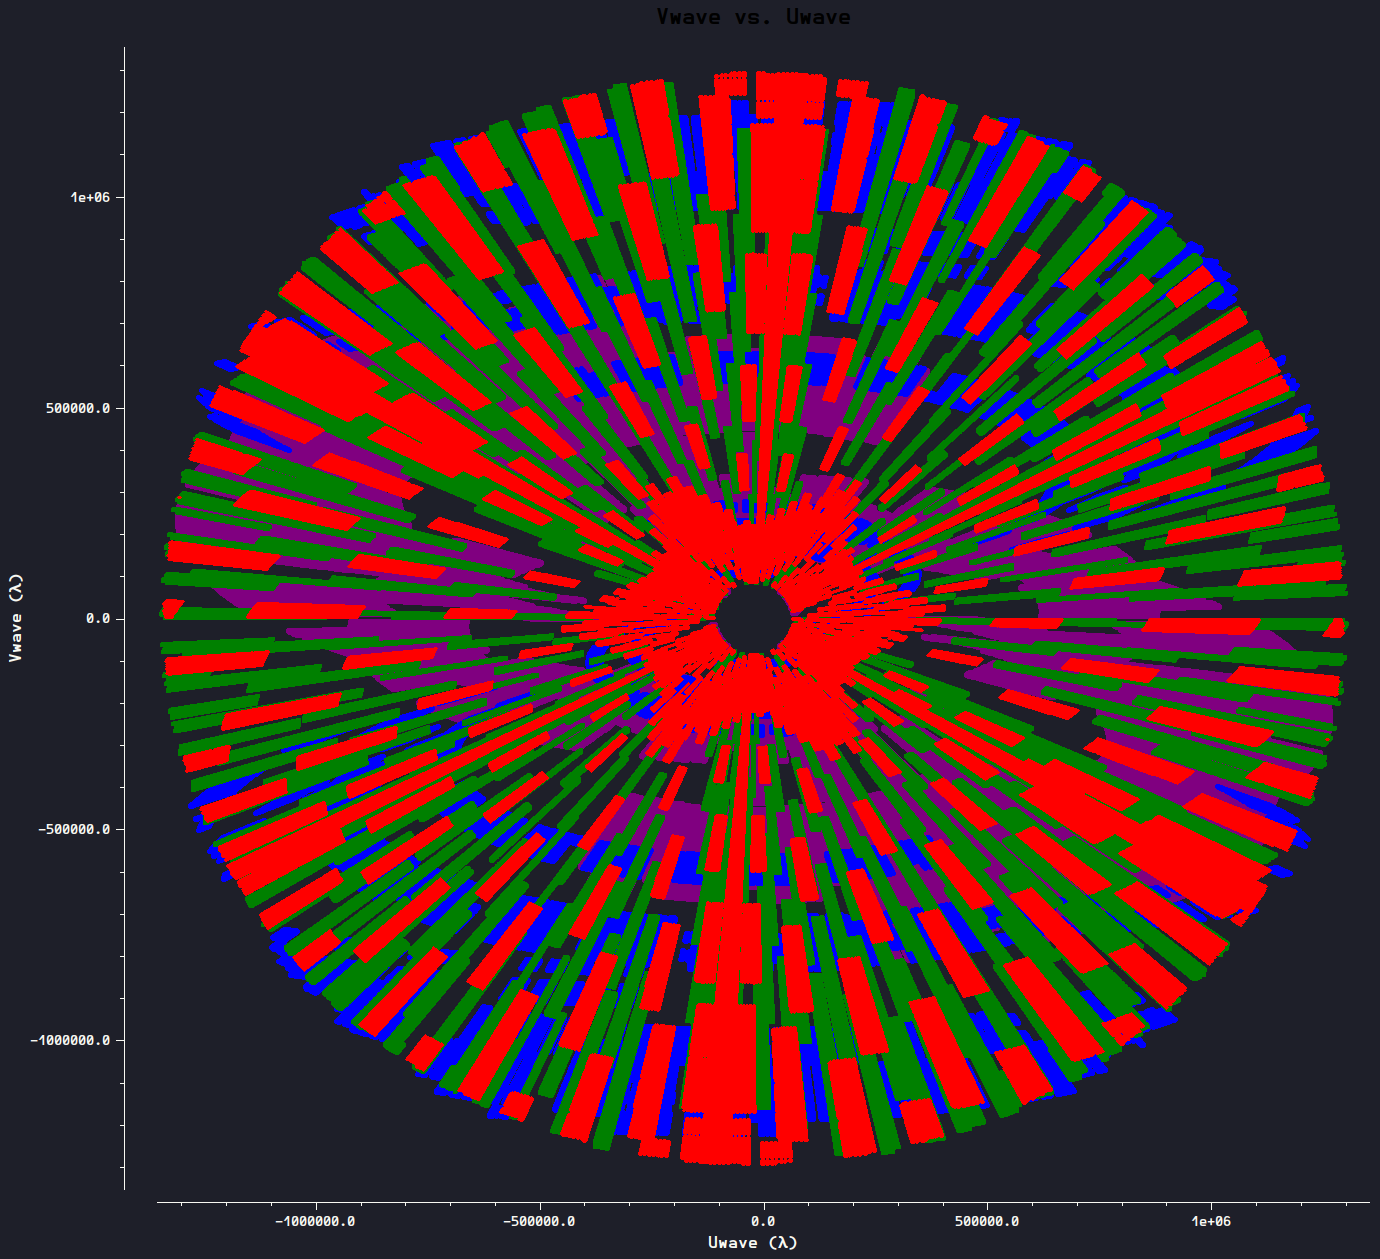